##### Trabalho Final - Análise de Dados com Python

Dataset: https://www.kaggle.com/camnugent/california-housing-prices

### Enunciado

A partir dos dados housing.csv, realize toda análise exploratória necessária e prepare os dados para algoritmos de machine learning usando a Scikit-Learn. Treine um modelo de regressão linear que prediga a variável meta (median_house_value) e cujo valor de RMSE seja menor ou igual a 69000. 

# Imports

In [430]:
import math
import pandas  as pd
import seaborn as sns
import numpy   as np
import xgboost as xgb

from IPython.core.display    import HTML
from sklearn.metrics         import mean_absolute_error, mean_squared_error
from sklearn.ensemble        import RandomForestRegressor
from sklearn.preprocessing   import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.linear_model    import LinearRegression
from sklearn.model_selection import train_test_split, KFold

# Funções auxiliares

In [662]:
def root_mean_square_percentage_error(y, yhat):
    rmspe = np.sqrt(np.mean(np.square(((y - yhat) / y)), axis=0))
    return rmspe

# Função para calculo da porcentagem do erro médio
def mean_percentage_error(y, yhat):
    return np.mean((y - yhat) / y) 

# Função para calculo da porcentagem do erro médio absoluto
def mean_absolute_percentage_error(y, yhat):
    return np.mean(np.abs((y - yhat) / y))

# Função que retorna todos os erros calculados
def ml_error(nome_model, y, yhat):
    mae = mean_absolute_error(y, yhat)
    mape = mean_absolute_percentage_error(y, yhat)
    rmspe = root_mean_square_percentage_error(y, yhat)
    rmse = np.sqrt(mean_squared_error(y, yhat))
    
    
    return pd.DataFrame({'Model Name': nome_model,
                          'MAE': mae,
                          'MAPE': mape,
                          'RMSPE': rmspe,
                          'RMSE': rmse}, index=[0])

def validacao_cruzada(df, features, target, kfold, nome_model, model, verbose=False):
    # Numero de kfolds
    kf = KFold(n_splits=kfold,  random_state=42, shuffle=True)
    
    # Inicio das variaveis listas para armazenar os valores das métricas
    mae_list = []
    rmse_list = []
    mape_list = []
    r2_list = []
    x = 1
    
    # Loop de iteração para rodar cada KFOLD
    for train_index, test_index in kf.split(df):
        
        # Print do KFOLD em execução
        if verbose:
            print('\nKFold numero: {}'.format(x))
        
        # Definindo dados treino e teste
        X_treino, X_val = df.loc[train_index,features], df.loc[test_index,features]
        y_treino, y_val = df.loc[train_index,target], df.loc[test_index,target]

        # Modelo
        m = model.fit(X_treino, y_treino)
        
        # Armazenando acucaria
        r2_list.append(m.score(X_val, y_val))
        
        # Predição
        yhat = m.predict(X_val)
        
        # Voltando os dados ao normal
        yhat = np.expm1(yhat)
        yhat = mms_y.inverse_transform(yhat.reshape(-1,1))       
        y_val = np.expm1(y_val)
        y_val = mms_y.inverse_transform(y_val)

        # Performance 
        m_result = ml_error(nome_model, y_val, yhat)
        
        # Armazenando a performance para cada iteração KFOLD
        mae_list.append(m_result['MAE'])
        mape_list.append(m_result['MAPE'])
        rmse_list.append(m_result['RMSE'])
        
        x=x+1
    # Retorna um dataframe com a média e desvio padrão das 5 iterações do KFOLD
    return pd.DataFrame({'Nome modelo': nome_model,
                         'MAE CV': np.round(np.mean(mae_list), 2).astype(str) + ' +/- ' + np.round(np.std(mae_list), 2).astype(str),
                         'MAPE CV': np.round(np.mean(mape_list), 2).astype(str) + ' +/- ' + np.round(np.std(mape_list), 2).astype(str),
                         'RMSE CV': np.round(np.mean(rmse_list), 2).astype(str) + ' +/- ' + np.round(np.std(rmse_list), 2).astype(str),
                         'R2 CV': np.round(np.mean(r2_list), 2).astype(str) + ' +/- ' + np.round(np.std(r2_list), 2).astype(str)}, index = [0])



# Função para definir algumas configurações de graficos
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [20, 15]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = 30
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()
    
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


# Carregando os dados

In [432]:
# leitura dos dados
df = pd.read_csv('bases/housing.csv')
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


# Descrição dos dados

In [433]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [434]:
print('Numero de Linhas: {}'.format(df.shape[0]))
print('Numero de Colunas: {}'.format(df.shape[1]))

Numero de Linhas: 20640
Numero de Colunas: 10


In [435]:
# Verificação de NA's
df.isna().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

In [436]:
# Podemos verificar que a variavel total_bedrooms possui alguns valores NA's
df[df['total_bedrooms'].isna()].sample(5)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
19959,-119.32,36.25,21.0,1231.0,NaN,609.0,206.0,2.8365,90000.0,INLAND
17840,-121.89,37.44,8.0,2534.0,NaN,1527.0,364.0,7.8532,422800.0,<1H OCEAN
15663,-122.44,37.80,52.0,3830.0,NaN,1310.0,963.0,3.4801,500001.0,NEAR BAY
18873,-122.22,38.08,37.0,2811.0,NaN,1574.0,516.0,3.1053,96700.0,NEAR BAY
15397,-117.20,33.24,12.0,4992.0,NaN,2106.0,801.0,6.2079,307300.0,<1H OCEAN


In [437]:
# Pela lógia, podemos considerar que os valores de NA's da variavel total_bedrooms podem assumir o valor de 0, já que não temos essa informação
df['total_bedrooms'].fillna(0, inplace= True)
df.isna().sum()

longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
median_house_value    0
ocean_proximity       0
dtype: int64

# Estatistica descritiva

## Variaveis numéricas

In [438]:
df1 = df.copy()

In [439]:
# Separando dados númericos e categóricos
# Numericos
df1_num = df1.select_dtypes(include=['float64'])
# Categóricos
df1_cat = df1.select_dtypes(include=['object'])

In [440]:
# Numericos
# Tendencias central - média, mediana
ct1 = pd.DataFrame( df1_num.apply( np.mean ) ).T
ct2 = pd.DataFrame( df1_num.apply( np.median ) ).T

# Dispersão - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( df1_num.apply( np.std ) ).T
d2 = pd.DataFrame( df1_num.apply( min ) ).T
d3 = pd.DataFrame( df1_num.apply( max ) ).T
d4 = pd.DataFrame( df1_num.apply(lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( df1_num.apply(lambda x: x.skew() ) ).T
d6 = pd.DataFrame( df1_num.apply(lambda x: x.kurtosis() ) ).T

# Concatenando todas as estatisticas criadas
m = pd.concat( [d2,d3,d4,ct1,ct2,d1,d5,d6] ).T.reset_index()
m.columns = ['variaveis', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,variaveis,min,max,range,mean,median,std,skew,kurtosis
0,longitude,-124.3500,-114.3100,10.0400,-119.569704,-118.4900,2.003483,-0.297801,-1.330152
1,latitude,32.5400,41.9500,9.4100,35.631861,34.2600,2.135901,0.465953,-1.117760
2,housing_median_age,1.0000,52.0000,51.0000,28.639486,29.0000,12.585253,0.060331,-0.800629
3,total_rooms,2.0000,39320.0000,39318.0000,2635.763081,2127.0000,2181.562402,4.147343,32.630927
4,total_bedrooms,0.0000,6445.0000,6445.0000,532.476211,431.0000,422.668093,3.411128,21.633064
5,population,3.0000,35682.0000,35679.0000,1425.476744,1166.0000,1132.434688,4.935858,73.553116
6,households,1.0000,6082.0000,6081.0000,499.539680,409.0000,382.320491,3.410438,22.057988
7,median_income,0.4999,15.0001,14.5002,3.870671,3.5348,1.899776,1.646657,4.952524
8,median_house_value,14999.0000,500001.0000,485002.0000,206855.816909,179700.0000,115392.820404,0.977763,0.327870


## Variaveis categóricas

In [441]:
# Categoricos
df1_cat.value_counts()

ocean_proximity
<1H OCEAN          9136
INLAND             6551
NEAR OCEAN         2658
NEAR BAY           2290
ISLAND                5
dtype: int64

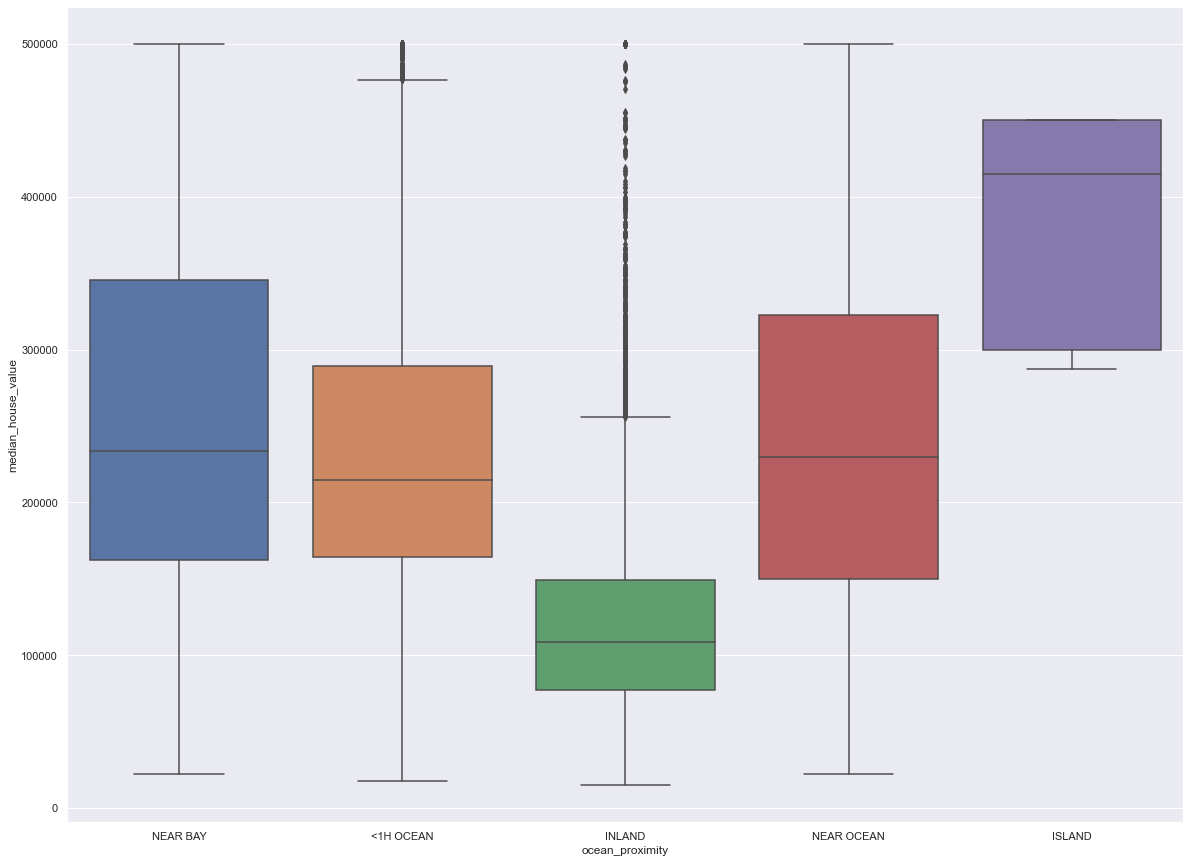

In [442]:
sns.boxplot( x='ocean_proximity', y='median_house_value', data=df1 )

Podemos observar que a categoria "Island" tem a maior concentração de preços mais altos, enquanto a categoria "Inland" tem a maior concentração de preços mais baixos, porém, com muitos outliers assumindo preços altos

# Análise Exploratória

## Análise Univariada

### Variavel Resposta

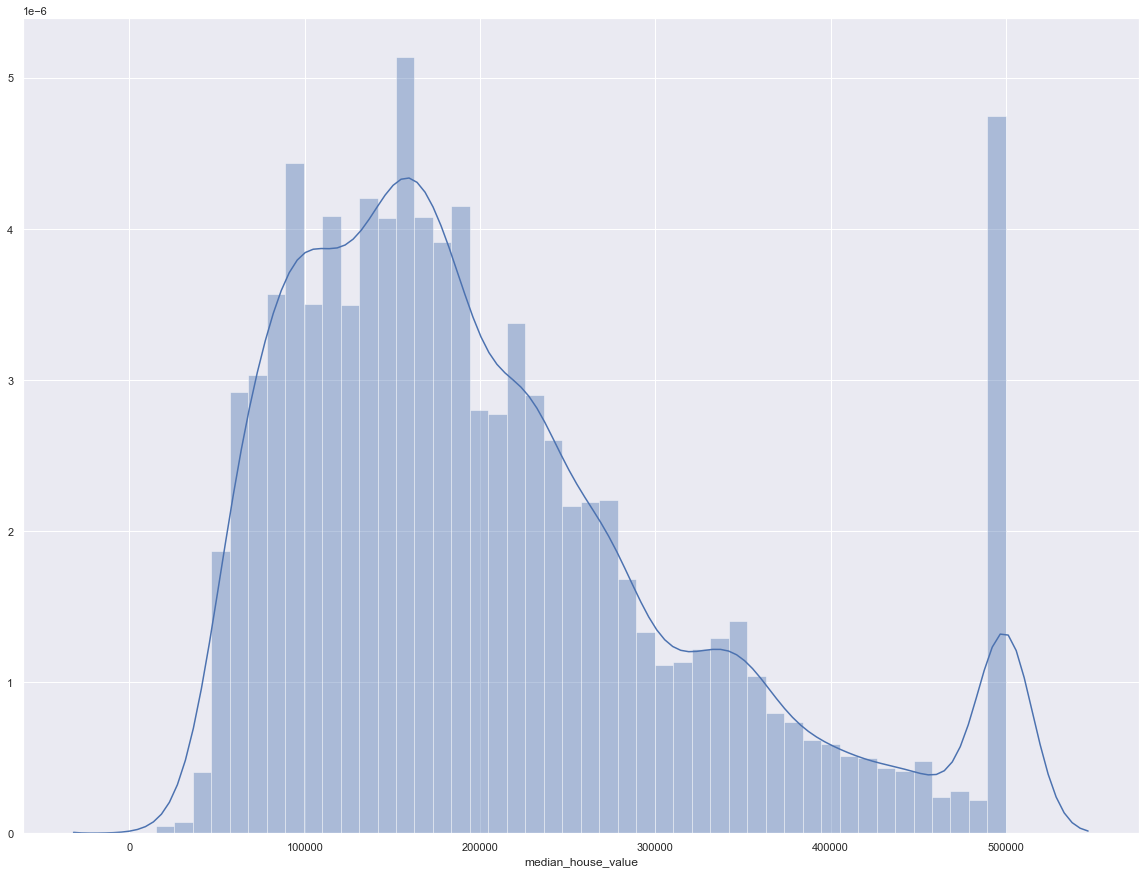

In [443]:
aux1 = df1[df1['median_house_value'] < 500000 ]
sns.distplot(df1['median_house_value'] )

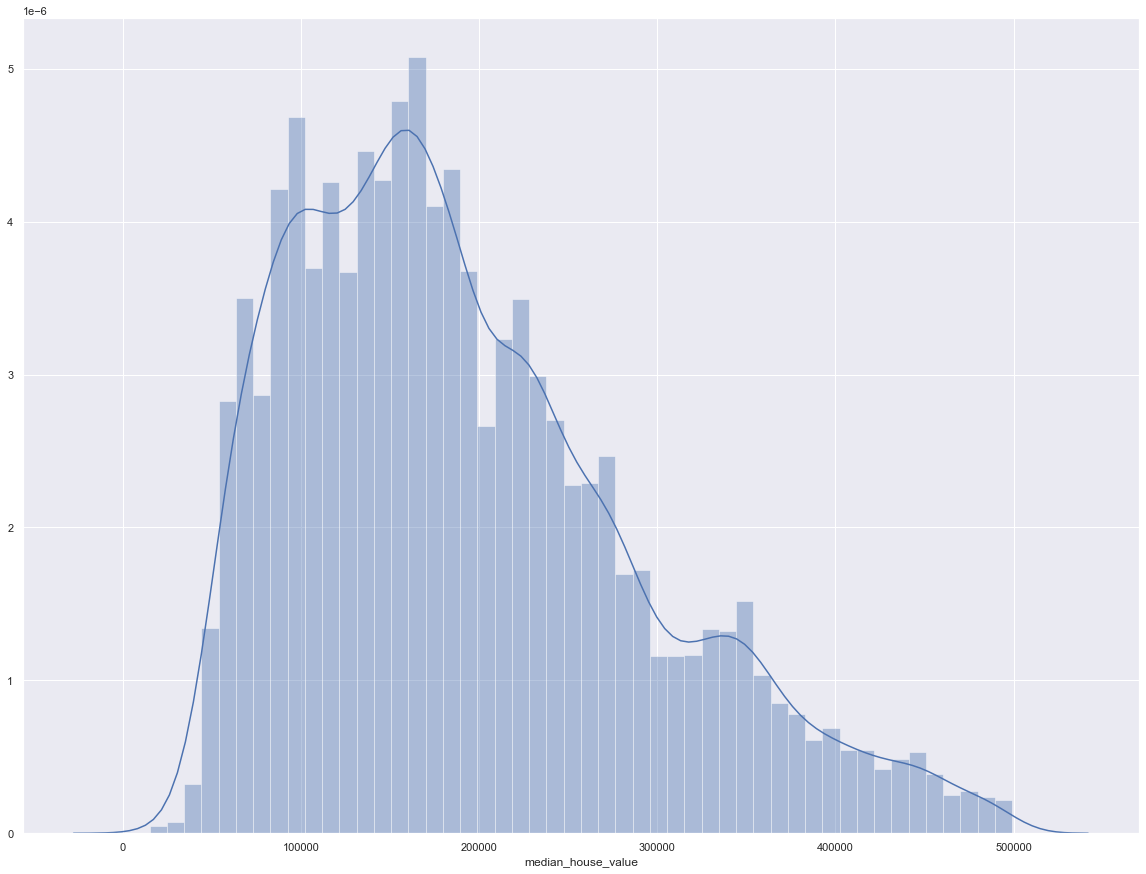

In [444]:
sns.distplot(aux1['median_house_value'])

### Variveis Numericas

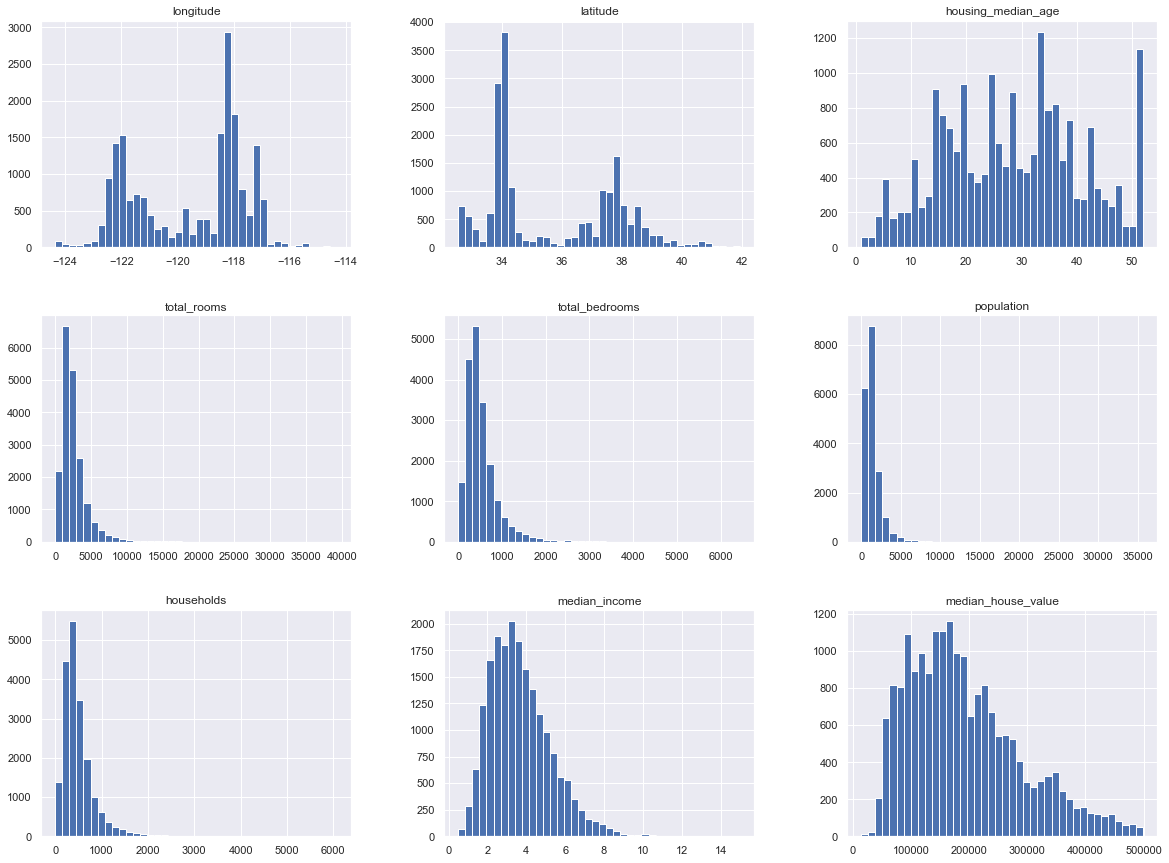

In [445]:
aux1.hist(bins = 40)
plt.show()

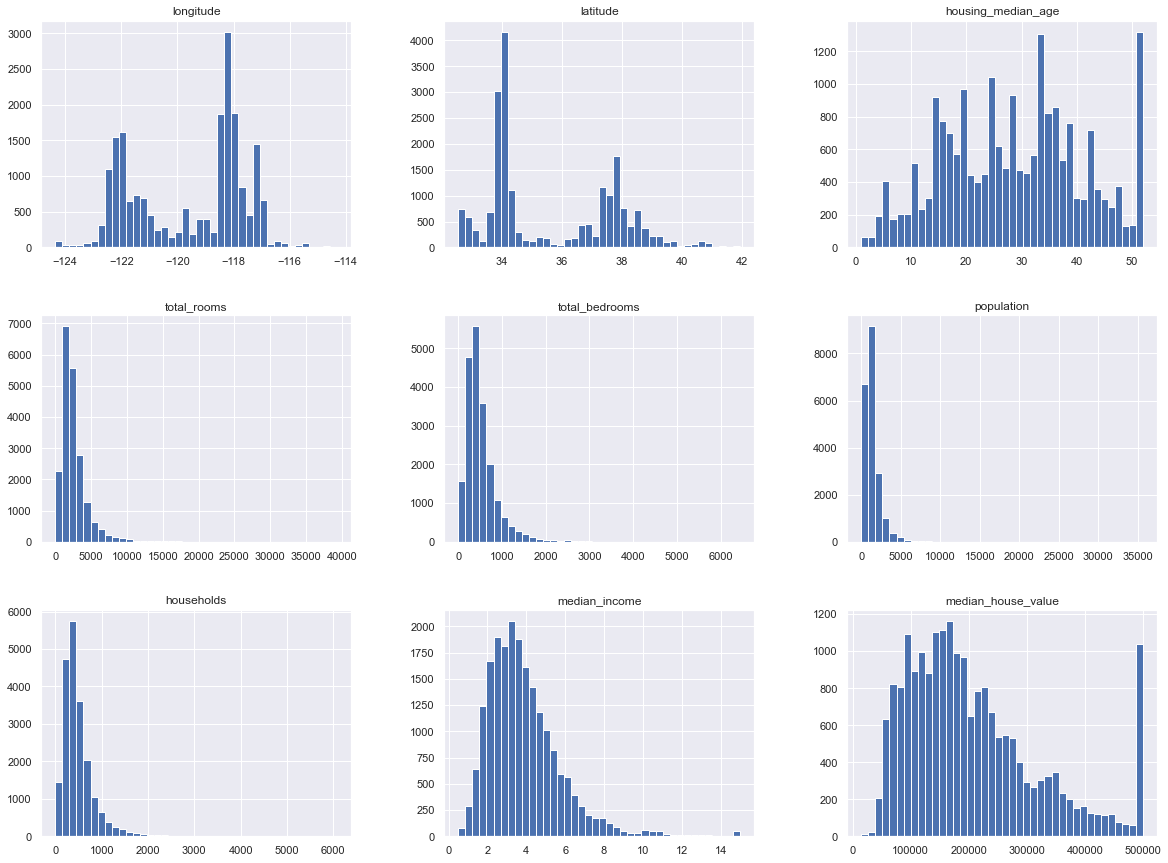

In [446]:
df1_num.hist(bins=40)
plt.show()

### Variveis Categóricas

In [447]:
df['ocean_proximity'].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

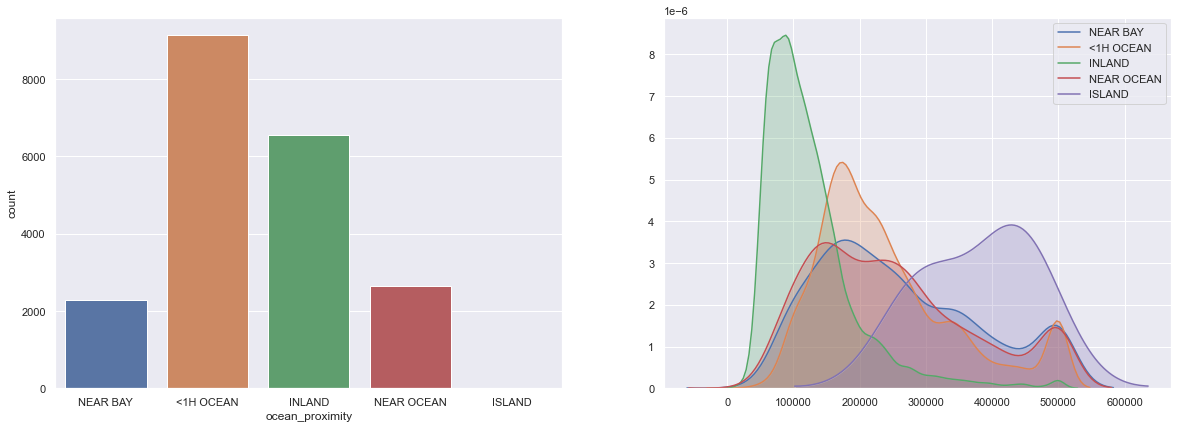

In [448]:
plt.subplot(2, 2, 1)
sns.countplot(df1['ocean_proximity'])

plt.subplot(2, 2, 2)
sns.kdeplot(df1[df1['ocean_proximity'] == 'NEAR BAY']['median_house_value'], label='NEAR BAY', shade=True)
sns.kdeplot(df1[df1['ocean_proximity'] == '<1H OCEAN']['median_house_value'], label='<1H OCEAN', shade=True)
sns.kdeplot(df1[df1['ocean_proximity'] == 'INLAND']['median_house_value'], label='INLAND', shade=True)
sns.kdeplot(df1[df1['ocean_proximity'] == 'NEAR OCEAN']['median_house_value'], label='NEAR OCEAN', shade=True)
sns.kdeplot(df1[df1['ocean_proximity'] == 'ISLAND']['median_house_value'], label='ISLAND', shade=True)


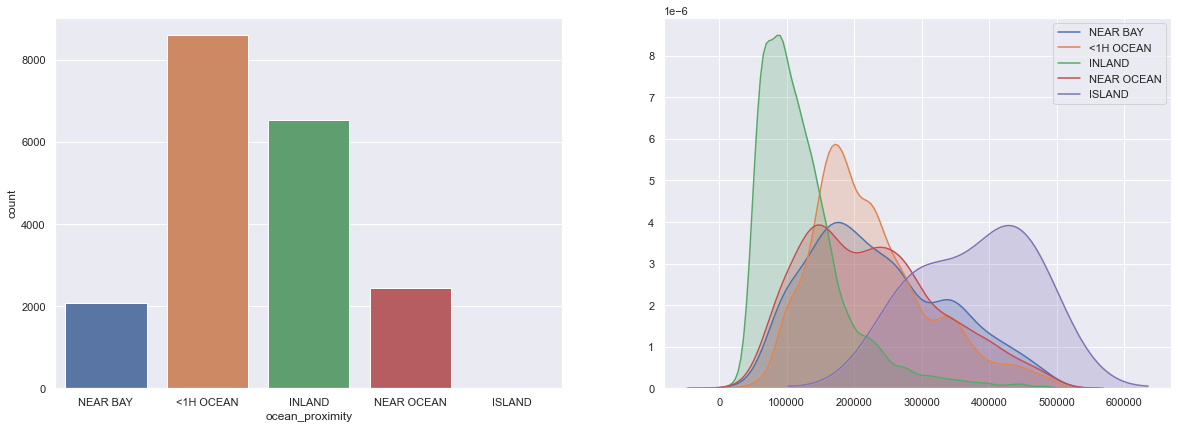

In [449]:
aux1 = df1[df1['median_house_value'] < 500000]
plt.subplot(2, 2, 1)
sns.countplot(aux1['ocean_proximity'])

plt.subplot(2, 2, 2)
sns.kdeplot(aux1[aux1['ocean_proximity'] == 'NEAR BAY']['median_house_value'], label='NEAR BAY', shade=True)
sns.kdeplot(aux1[aux1['ocean_proximity'] == '<1H OCEAN']['median_house_value'], label='<1H OCEAN', shade=True)
sns.kdeplot(aux1[aux1['ocean_proximity'] == 'INLAND']['median_house_value'], label='INLAND', shade=True)
sns.kdeplot(aux1[aux1['ocean_proximity'] == 'NEAR OCEAN']['median_house_value'], label='NEAR OCEAN', shade=True)
sns.kdeplot(aux1[aux1['ocean_proximity'] == 'ISLAND']['median_house_value'], label='ISLAND', shade=True)


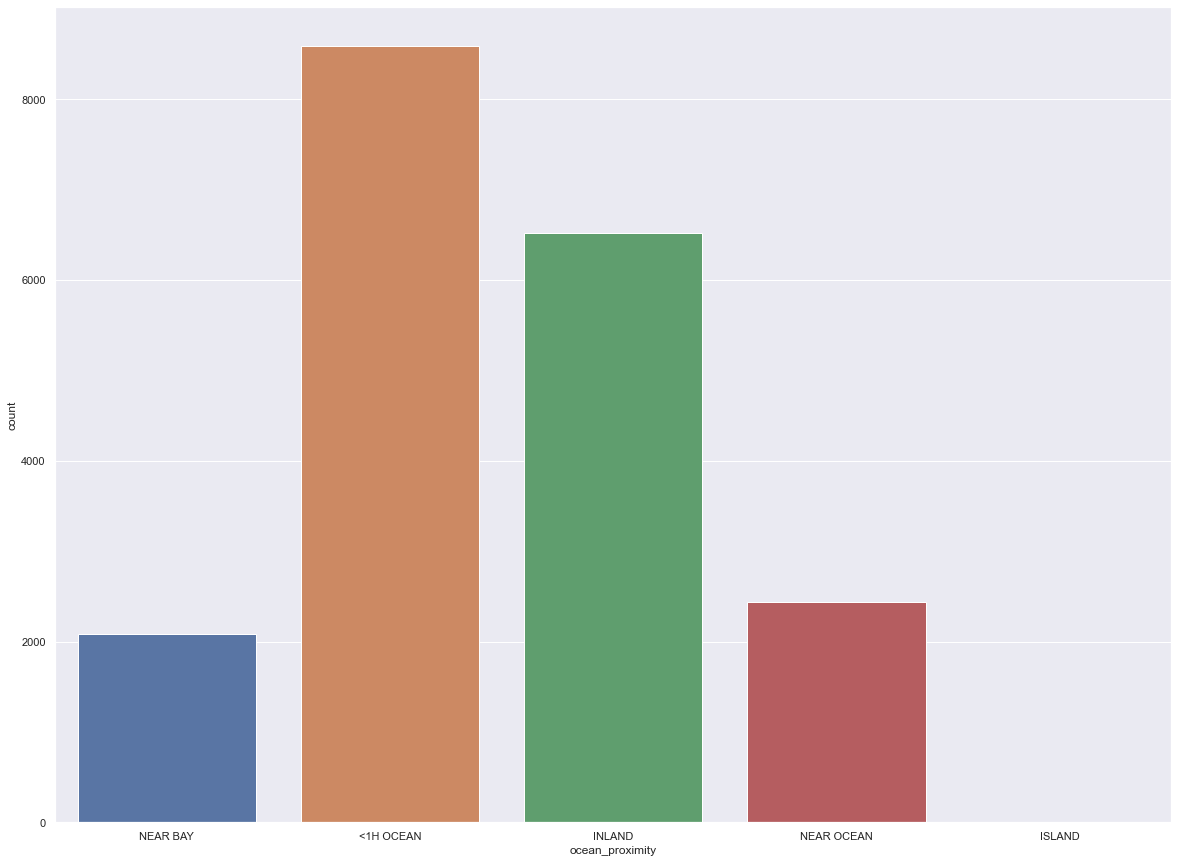

In [450]:
sns.countplot(aux1['ocean_proximity'])

## Análise Bivariada

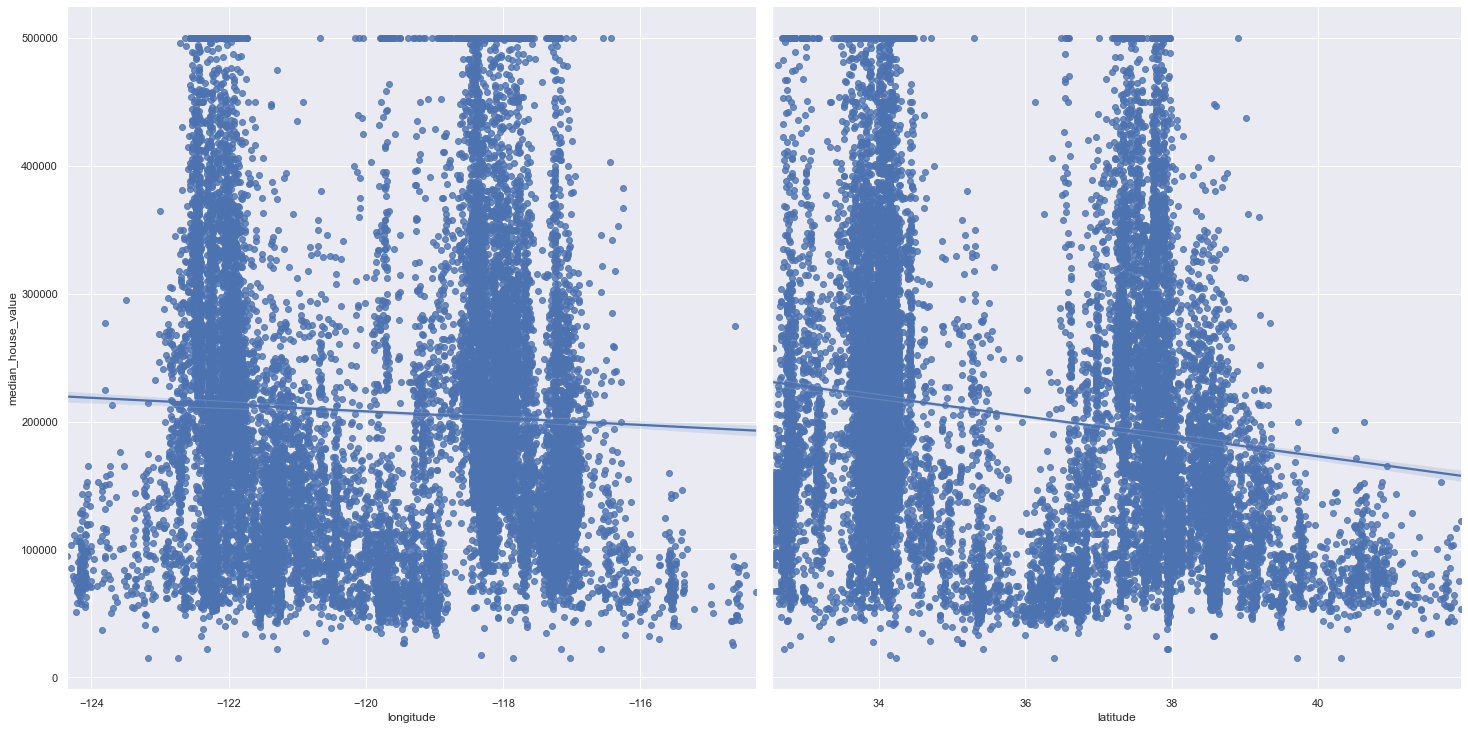

In [451]:
sns.pairplot(df1, y_vars = 'median_house_value', x_vars=['longitude','latitude'], kind='reg', height=10)

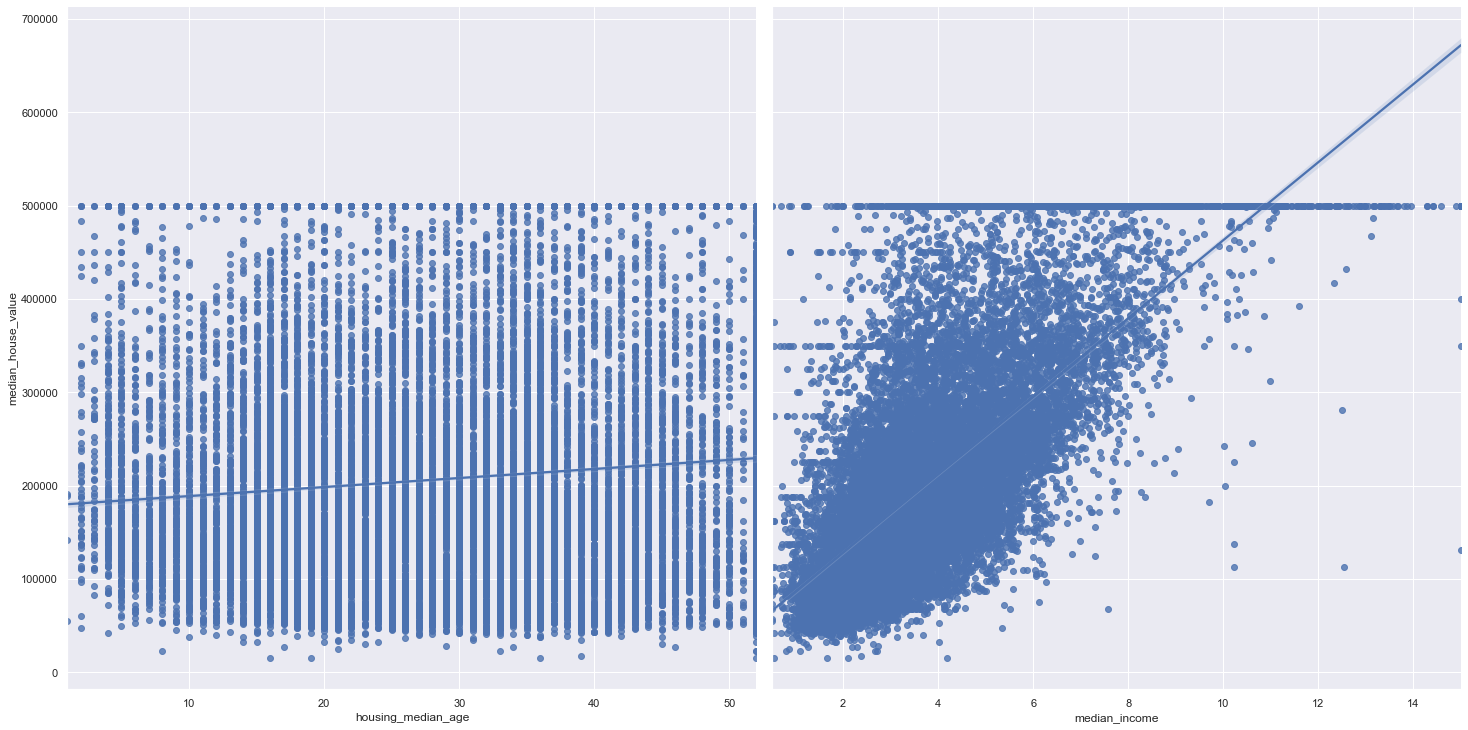

In [452]:
sns.pairplot(df1, y_vars = 'median_house_value', x_vars=['housing_median_age','median_income'], kind='reg', height=10)

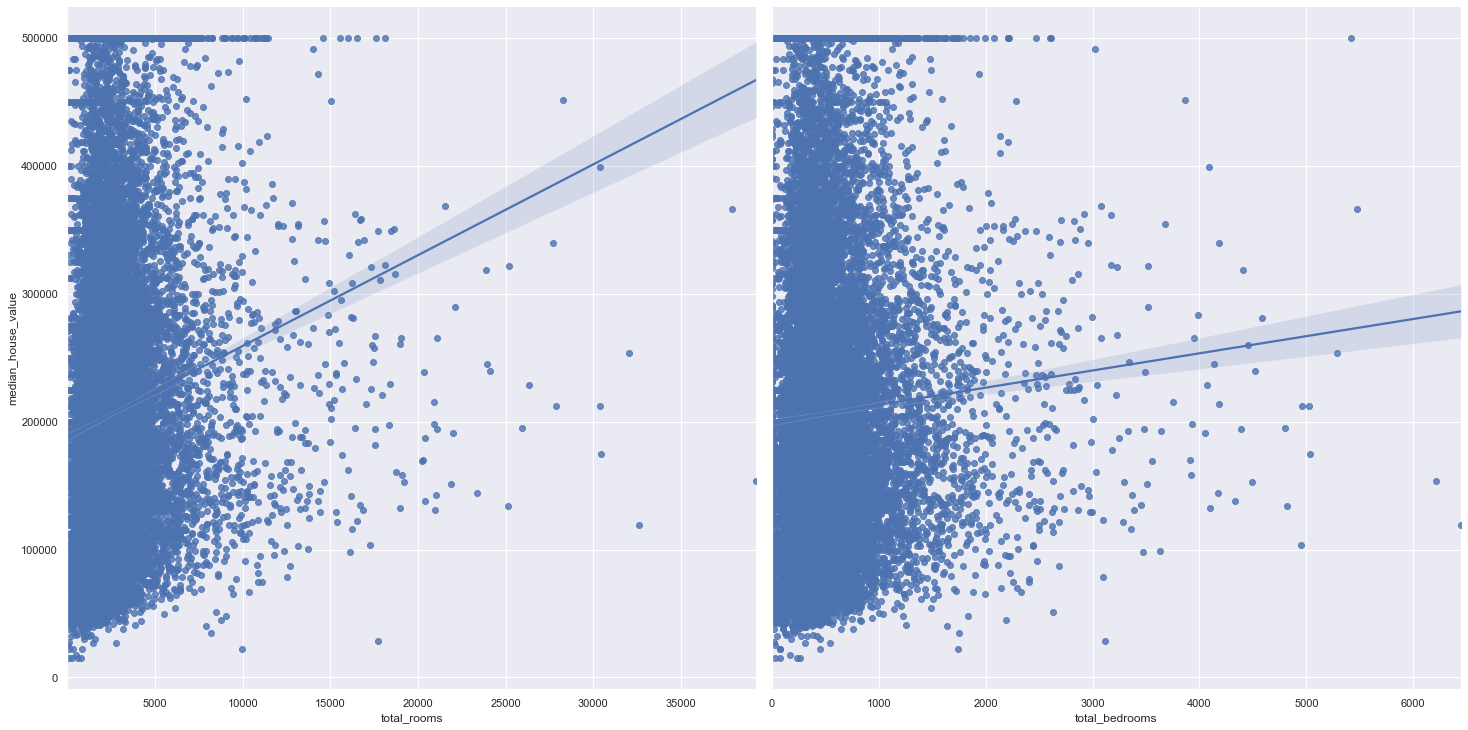

In [453]:
sns.pairplot(df1, y_vars = 'median_house_value', x_vars=['total_rooms','total_bedrooms'], kind='reg', height=10)

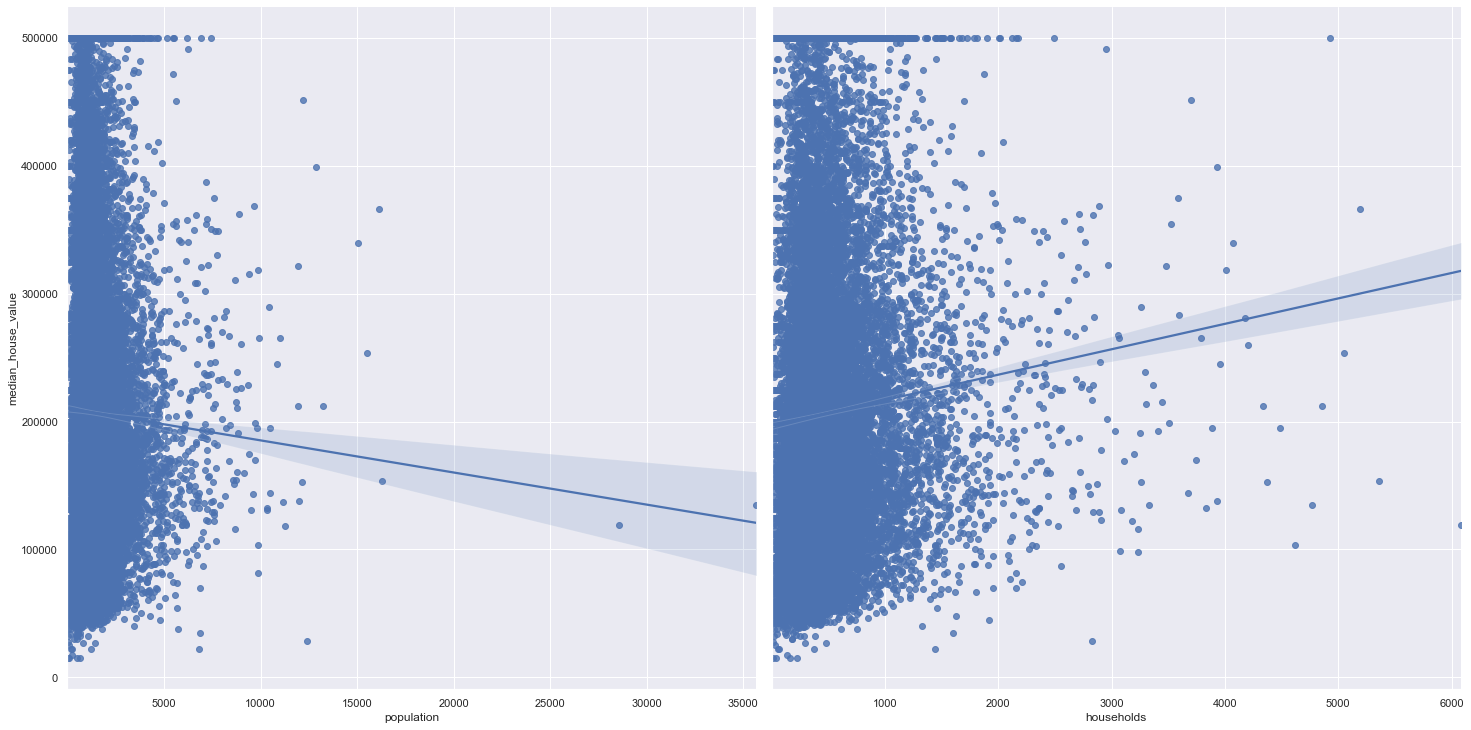

In [454]:
sns.pairplot(df1, y_vars = 'median_house_value', x_vars=['population','households'], kind='reg', height=10)

## Análise Multivariada

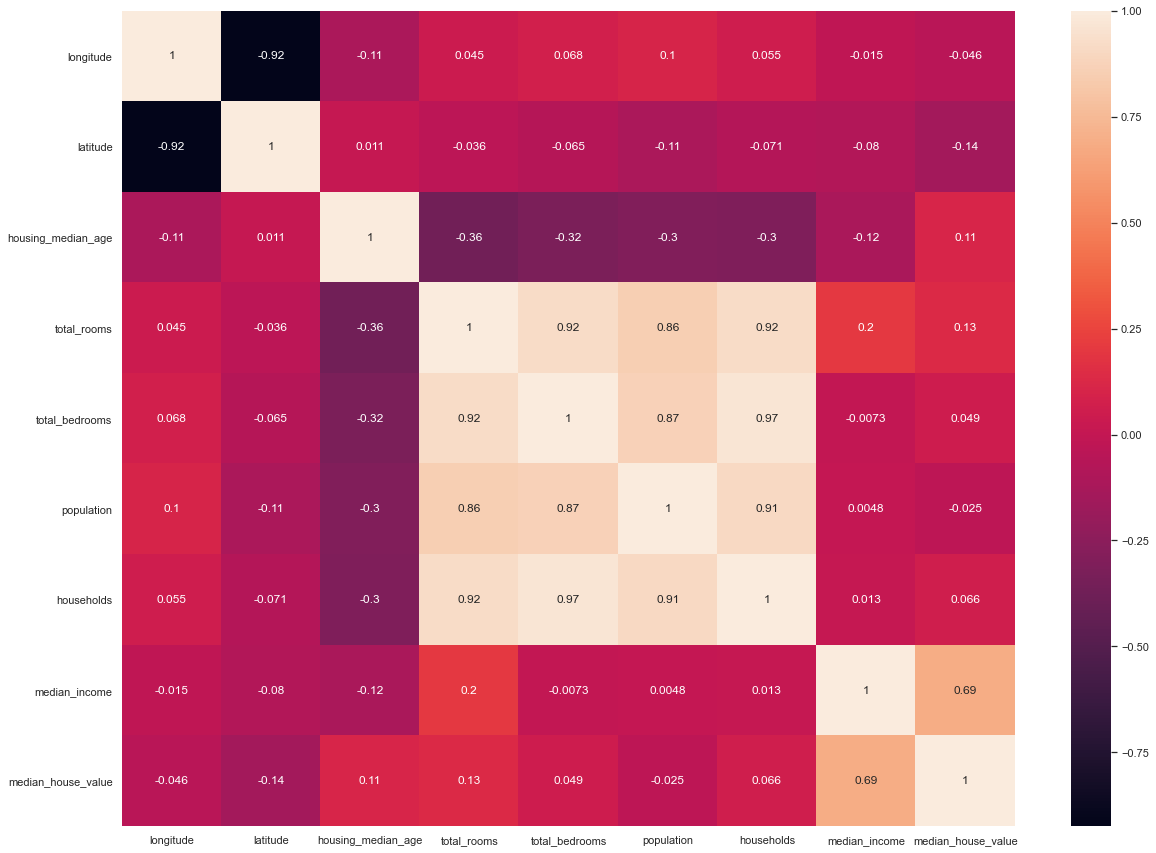

In [455]:
sns.heatmap(df1.corr(method = 'pearson'), annot = True)

# Pré - Processamento de dados

In [652]:
df2 = df1.copy()

In [653]:
# Com as análises anteriores, é evidente que a variavel resposta possui valores que estão distorcendo sua distribuição e 
# possivelmente podem acarretar à problemas no modelo de regressão, portanto, serão removidos
df2 = df2[df2['median_house_value'] <= 500000].reset_index()

## Scaling

In [654]:
# Robust Scaler, não sensivel a outliers, indicado para variaveis que possuem range muito grande devido a outliers
rs = RobustScaler()
# Min Max Scaler, sensivel a outliers, indicado para variaveis que não possuem outliers muito discrepantes
mms = MinMaxScaler()
mms_y = MinMaxScaler()

df2['total_rooms'] = rs.fit_transform(df2[['total_rooms']].values)
df2['total_bedrooms'] = rs.fit_transform(df2[['total_bedrooms']].values)
df2['population'] = rs.fit_transform(df2[['population']].values)
df2['households'] = rs.fit_transform(df2[['households']].values)
df2['median_income'] = rs.fit_transform(df2[['median_income']].values)

df2['housing_median_age'] = mms.fit_transform(df2[['housing_median_age']].values)
df2['longitude'] = mms.fit_transform(df2[['longitude']].values)
df2['latitude'] = mms.fit_transform(df2[['latitude']].values)

df2['median_house_value'] = mms_y.fit_transform(df2[['median_house_value']].values)

## Encoding

In [655]:
# Vamos aplicar um encoding para a variavel categorica 'ocean_proximity'
le = LabelEncoder()
df2['ocean_proximity'] = le.fit_transform(df2['ocean_proximity'])
df2['ocean_proximity'] = df2['ocean_proximity'].astype(float64)

# df2 = pd.get_dummies(df2, prefix=['ocean_proximity'], columns = ['ocean_proximity'])

## Transformação da variavel resposta

In [656]:
# Aplicando transformação logaritma
df2['median_house_value'] = np.log1p(df2['median_house_value'])

# Modelagem de Machine Learning

In [657]:
df3 = df2.copy()

In [658]:
# Definição de features de treino e target
features_treino = ['longitude', 'latitude', 'housing_median_age', 'total_rooms',
                   'total_bedrooms', 'population', 'households', 'median_income', 'ocean_proximity']

feature_target = ['median_house_value']

## Validação cruzada dos modelos

In [668]:
lr = LinearRegression()
rf = RandomForestRegressor()
xgbr = xgb.XGBRegressor(objective = 'reg:squarederror')

### Regressão Linear

In [669]:
lr_results = validacao_cruzada(df3, features_treino, feature_target, 5, 'Regressão Linear', lr, verbose = True)


KFold numero: 1

KFold numero: 2

KFold numero: 3

KFold numero: 4

KFold numero: 5


### Random Forest

In [670]:
rf_results = validacao_cruzada(df3, features_treino, feature_target, 5, 'Random Forest', rf, verbose = True)


KFold numero: 1


<ipython-input-662-a54a43332a14>:50: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  m = model.fit(X_treino, y_treino)



KFold numero: 2


<ipython-input-662-a54a43332a14>:50: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  m = model.fit(X_treino, y_treino)



KFold numero: 3


<ipython-input-662-a54a43332a14>:50: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  m = model.fit(X_treino, y_treino)



KFold numero: 4


<ipython-input-662-a54a43332a14>:50: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  m = model.fit(X_treino, y_treino)



KFold numero: 5


<ipython-input-662-a54a43332a14>:50: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  m = model.fit(X_treino, y_treino)


### XGBoost

In [671]:
xgb_results = validacao_cruzada(df3, features_treino, feature_target, 5, 'XGBoost', xgbr, verbose = True)


KFold numero: 1

KFold numero: 2

KFold numero: 3

KFold numero: 4

KFold numero: 5


## Resultado Final

In [672]:
geral_results = pd.concat([lr_results, rf_results, xgb_results])
geral_results

,Nome modelo,MAE CV,MAPE CV,RMSE CV,R2 CV
0,Regressão Linear,44810.18 +/- 700.69,0.28 +/- 0.0,61490.31 +/- 890.92,0.62 +/- 0.01
0,Random Forest,29616.67 +/- 570.26,0.17 +/- 0.0,44703.81 +/- 782.89,0.81 +/- 0.0
0,XGBoost,35924.61 +/- 748.62,0.21 +/- 0.0,50999.0 +/- 715.72,0.74 +/- 0.0


**Todos os modelos ficaram abaixo do valor solicitado (69000 RMSE), porém, o melhor de todos foi o de Random Forest**

# Predict modelo Regressão Linear

In [698]:
d4 = df3.copy()

In [699]:
X = d4.drop(columns='median_house_value')
y = d4['median_house_value']

In [700]:
X_treino, X_teste, y_treino, y_teste = train_test_split(X,y, test_size = 0.3, random_state = 42)

In [701]:
# Fit do modelo de Regressão linear
model_lr = lr.fit(X_treino, y_treino)

# Predict do modelo
predicted = model_lr.predict(X_teste)

In [702]:
# Voltando os dados ao normal
predicted = np.expm1(predicted)
predicted = mms_y.inverse_transform(predicted.reshape(-1,1))

# Adicionando colunca predicted no dataframe
X_teste['predicted'] = predicted

<ipython-input-702-085190e88f9f>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_teste['predicted'] = predicted


In [703]:
X_teste

,index,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,predicted
14447,15065,0.736056,0.027630,0.450980,0.227111,0.740741,0.253684,0.716049,-0.785242,0.0,150886.471722
13921,14534,0.718127,0.041445,0.254902,-0.098098,0.085470,0.027368,-0.064815,0.370124,0.0,205261.089570
12981,13570,0.703187,0.170032,1.000000,-0.254459,-0.475783,-0.561053,-0.478395,0.290933,1.0,190198.067111
2579,2607,0.033865,0.895855,0.392157,-0.355529,-0.324786,-0.248421,-0.339506,0.042806,0.0,134439.809682
12162,12750,0.295817,0.646121,0.647059,0.143282,0.504274,-0.054737,0.558642,-0.608036,1.0,121472.483128
...,...,...,...,...,...,...,...,...,...,...,...
2872,2900,0.531873,0.300744,0.843137,-0.902497,-0.846154,-0.857895,-0.895062,-0.959286,1.0,105525.857674
17714,18661,0.240040,0.470776,0.588235,-0.221760,-0.031339,-0.455789,-0.172840,-0.453741,4.0,198068.811171
12525,13113,0.297809,0.622742,0.333333,1.606421,1.185185,1.214737,1.333333,0.352661,1.0,163103.115637
14904,15537,0.721116,0.061637,0.882353,-1.224138,-1.196581,-1.178947,-1.228395,0.206732,0.0,208099.708471
